# Import

In [1]:
import os
import glob
import pandas as pd
#from multiprocessing import Pool

import bed_lib as bl
import div_trans_lib as dt
import basics_counts as bc
import basics_bam as bb

%matplotlib inline

In [2]:
# To not have to restart the kernel everytime changes are made in modules
%load_ext autoreload
%autoreload 2

**WARNINGS**

- TRY filtering only uniquely mapping reads (MAPQ 255) and compare with filtering only primary 

**TO EXPLAIN**

There is a rationale being only using reads (and not fragments), since we are only interested in ends of - reads first and then beginnings of + reads 
> Actually might be interesting to try using only one reads of the pair (TO CHECK)

## Input

In [42]:
bam_paths = glob.glob('../data/bams/*_coordSort_filt.bam')
#bam_paths = glob.glob('../data/bams/test/*.bam')
bam_paths

['../data/bams/VEUDE_A_1_coordSort_filt.bam',
 '../data/bams/Compoud_A_1_coordSort_filt.bam']

### For testing: extract a list of intervals of interest in a single bam

In [43]:
# For testing generate bam of regions of interest
#intervals = ['2:231,487,450-231,560,819', '1:912,436-960,073',
#             '1:14,642,898-14,652,296', '1:16,977,736-17,015,333',
#             '1:17,048,606-17,086,203', '1:17,212,506-17,250,102',
#             '14:81,416,025-81,468,815']

intervals = ["5:19004800-19044400", "6:87796000-87830200", "4:23304600-23335200", "1:126681200-126836600",
"4:83935200-83955400", "2:43480600-43496000", "3:46343200-46380000", "1:175072578-175073731",
"1:28981074-28982933", "10:31549665-31550835", "10:48608841-48609859", "10:69546063-69547482",
"11:108491750-108493969", "11:108494858-108496123", "11:126763239-126764653", "11:76317699-76318864",
"12:101959588-101960882", "13:21761824-21763230", "13:81026233-81027806", "14:104537043-104538608",
"14:55386994-55388122", "15:47936402-47937576", "16:85052325-85054726", "18:44809957-44811180",
"2:157752315-157754855", "2:166296503-166297685", "2:187153516-187154852", "2:194340311-194341794",
"2:73949410-73950976", "2:77088433-77089662", "22:32696272-32698887", "3:117465398-117466937",
"3:161487733-161489121"]

bams = []

for bam in bam_paths:
    bam = bb.Bam(bam)
    bam = bam.multi_fetch(intervals)
    bam = bam.sort().make_index()
    bams.append(bam.path)

2018-08-01 11:18:32,469 - basics_bam.py - basics_bam - multi_fetch() - DEBUG - Extracting interval: 5:19004800-19044400 from BAM Object for file: ../data/bams/VEUDE_A_1_coordSort_filt.bam
2018-08-01 11:18:32,469 - basics_bam.py - basics_bam - multi_fetch() - DEBUG - Extracting interval: 5:19004800-19044400 from BAM Object for file: ../data/bams/VEUDE_A_1_coordSort_filt.bam
2018-08-01 11:18:32,469 - basics_bam.py - basics_bam - multi_fetch() - DEBUG - Extracting interval: 5:19004800-19044400 from BAM Object for file: ../data/bams/VEUDE_A_1_coordSort_filt.bam
2018-08-01 11:18:32,469 - basics_bam.py - basics_bam - multi_fetch() - DEBUG - Extracting interval: 5:19004800-19044400 from BAM Object for file: ../data/bams/VEUDE_A_1_coordSort_filt.bam
2018-08-01 11:18:32,469 - basics_bam.py - basics_bam - multi_fetch() - DEBUG - Extracting interval: 5:19004800-19044400 from BAM Object for file: ../data/bams/VEUDE_A_1_coordSort_filt.bam
DEBUG:basics_bam.py - basics_bam:Extracting interval: 5:1900

# Analyse from bams

The idea here is to detect divergent transcription directly from a sorted bam.
This would fix some limitations of the first method.

ALGO: 
Look through the coordinated sorted bam file, registering the transcribed strand for each reads.

Since we have paired strand-specific libraries (rf):
- first of the pair, reverse complemented = + strand
- second of the pair, NOT reverse complemented = + strand
- first of the pair, NOT reverse complemented = - strand
- second of the pair, reverse complemented = - strand

When a change of sign is detected, calculate the distance with the previous transcript on the opposite strand 

## Detect divergent transcription events accross sorted bam

In [44]:
div_trans_beds = [dt.get_divergent_transcription_beds(bam, distance=500) for bam in bams]

In [45]:
div_trans_beds[0].head()

2	43484470	43484590	div_event_1	0	.
2	43484637	43484769	div_event_2	0	.
2	43484785	43484926	div_event_3	0	.
2	43484843	43484941	div_event_4	0	.








Merge the divergent transcription events detected:

### Filter based on featureCounts

In [46]:
div_trans_beds_count_filtered = []

for bed, bam in zip(div_trans_beds, bams):
    div_trans_beds_count_filtered.append(dt.filter_by_counts(bed, bam, 
                                                       '../data/genome_chro_size.tab', 
                                                       flank=500, count_thres=10, count_ratio_thres=5))

2018-08-01 11:19:11,492 - basics_bam.py - basics_bam - count_over_intervals() - INFO - Starting count on intervals
2018-08-01 11:19:11,492 - basics_bam.py - basics_bam - count_over_intervals() - INFO - Starting count on intervals
2018-08-01 11:19:11,492 - basics_bam.py - basics_bam - count_over_intervals() - INFO - Starting count on intervals
2018-08-01 11:19:11,492 - basics_bam.py - basics_bam - count_over_intervals() - INFO - Starting count on intervals
2018-08-01 11:19:11,492 - basics_bam.py - basics_bam - count_over_intervals() - INFO - Starting count on intervals
INFO:basics_bam.py - basics_bam:Starting count on intervals
2018-08-01 11:19:11,549 - basics_bam.py - basics_bam - count_over_intervals() - INFO - Starting count on intervals
2018-08-01 11:19:11,549 - basics_bam.py - basics_bam - count_over_intervals() - INFO - Starting count on intervals
2018-08-01 11:19:11,549 - basics_bam.py - basics_bam - count_over_intervals() - INFO - Starting count on intervals
2018-08-01 11:19:11,

### Filter based on deeptools bamCoverage

**WARNING** NEED TO REMOVE THE GL contigs (done manually for now)

In [47]:
div_trans_beds_cov_filtered = {}

for bed, bam in zip(div_trans_beds, bams):
    bed_sel, df_coverages = dt.filter_by_coverage(bed, bam, '../data/genome_chro_size.tab', 
                                                  flank=500, cov_thres=0.18, cov_ratio_thres=1.9, threads=4)
    
    div_trans_beds_cov_filtered[os.path.basename(bed.path)] = {'bed': bed_sel, 'coverage': df_coverages}

2018-08-01 11:19:24,171 -  - div_trans_lib - filter_by_coverage() - INFO - Calculate coverage for bam: ../data/bams/VEUDE_A_1_coordSort_filt_fetched_S.bam
INFO: - div_trans_lib:Calculate coverage for bam: ../data/bams/VEUDE_A_1_coordSort_filt_fetched_S.bam
2018-08-01 11:19:49,429 -  - div_trans_lib - filter_by_coverage() - INFO - Filtering intervals based on read coverage ...
INFO: - div_trans_lib:Filtering intervals based on read coverage ...
2018-08-01 11:19:49,441 -  - div_trans_lib - filter_by_coverage() - INFO - Filtering for <Bed object: VEUDE_A_1_coordSort_filt_fetched_S_divtrans> DONE.
INFO: - div_trans_lib:Filtering for <Bed object: VEUDE_A_1_coordSort_filt_fetched_S_divtrans> DONE.
2018-08-01 11:19:49,475 -  - div_trans_lib - filter_by_coverage() - INFO - Calculate coverage for bam: ../data/bams/Compoud_A_1_coordSort_filt_fetched_S.bam
INFO: - div_trans_lib:Calculate coverage for bam: ../data/bams/Compoud_A_1_coordSort_filt_fetched_S.bam
2018-08-01 11:20:17,975 -  - div_trans

In [58]:
div_trans_beds_cov_filtered['Compoud_A_1_coordSort_filt_fetched_S_divtrans.bed']['coverage'].head()

,counts_forward_upstream,base_coverage_forward_upstream,counts_reverse_upstream,base_coverage_reverse_upstream,ratio_upstream,counts_forward_downstream,base_coverage_forward_downstream,counts_reverse_downstream,base_coverage_reverse_downstream,ratio_downstream,forward_noise_ratio,reverse_noise_ratio
divtrans_event,,,,,,,,,,,,
div_event_1,2.875,0.055489,0.50,0.021739,0.391773,3.000000,0.070787,2.333333,0.031287,2.262487,1.043478,0.214286
div_event_10,0.000,0.000000,7.00,0.135000,inf,6.444444,0.141834,0.000000,0.000000,inf,inf,inf
div_event_11,2.200,0.047111,1.00,0.068889,1.462264,1.000000,0.011737,1.000000,0.076296,0.153838,0.454545,1.000000
div_event_12,1.600,0.061000,1.00,0.015833,0.259563,1.000000,0.024839,0.500000,0.016129,1.540000,0.625000,2.000000
div_event_13,1.000,0.004464,2.25,0.077500,17.360000,2.500000,0.044311,3.250000,0.101923,0.434753,2.500000,0.692308


In [12]:
div_trans_beds_filter_merged = [div_trans_beds_cov_filtered[x]['bed'].merge() for x in div_trans_beds_cov_filtered]

In [13]:
div_trans_beds_filter_merged[0].head()

1	714151	714194
1	714283	714530
1	730616	730753
1	738613	738752
1	745150	745297
1	895549	895646
1	935855	936208
1	1167596	1167602
1	1209055	1209209
1	1209326	1209428


# Filter divergent intervals events by overlap with CAGE TSS

Use FANTOM5 transcription initiation information obtained with CAGE data (either simple or divergent transcription) to filter divergent transcription events detected in RNA-seq alignments.

## Download cage peaks

In [14]:
%%bash

wget http://fantom.gsc.riken.jp/5/datafiles/latest/extra/CAGE_peaks/hg19.cage_peak_phase1and2combined_coord.bed.gz \
    -O ../data/cage_peaks.bed.gz
    
gunzip ../data/cage_peaks.bed.gz
    
# Convert to Ensembl type bed
sed 's/^chr//g' ../data/cage_peaks.bed | bedtools sort -i - > ../data/cage_peaks_clean.bed

# Separate two beds (one per strand) to later catch both cage transcription direction
#awk '$6~"+" {print}' ../data/cage_peaks_clean.bed > ../data/cage_peaks_plusStrand.bed
#awk '$6~"-" {print}' ../data/cage_peaks_clean.bed > ../data/cage_peaks_minusStrand.bed

# Cleanup
rm ../data/cage_peaks.bed
#rm ../data/cage_peaks_clean.bed

--2018-07-23 13:35:52--  http://fantom.gsc.riken.jp/5/datafiles/latest/extra/CAGE_peaks/hg19.cage_peak_phase1and2combined_coord.bed.gz
Resolving fantom.gsc.riken.jp... 134.160.84.66
Connecting to fantom.gsc.riken.jp|134.160.84.66|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4405584 (4,2M) [application/x-gzip]
Saving to: ‘../data/cage_peaks.bed.gz’

     0K .......... .......... .......... .......... ..........  1%  104K 41s
    50K .......... .......... .......... .......... ..........  2%  199K 31s
   100K .......... .......... .......... .......... ..........  3% 2,21M 21s
   150K .......... .......... .......... .......... ..........  4%  225K 20s
   200K .......... .......... .......... .......... ..........  5% 1,61M 16s
   250K .......... .......... .......... .......... ..........  6% 7,14M 14s
   300K .......... .......... .......... .......... ..........  8%  210K 14s
   350K .......... .......... .......... .......... ..........  9% 2,42M 12s
   40

## Filter divergent transcription events with CAGE dataset
### Detect divergent transcription in CAGE dataset

In [15]:
cage_bed = bl.Bed('../data/cage_peaks_clean.bed')
cage_div_trans_out = '../data/cage_div_trans.bed'

with open(cage_div_trans_out, 'w') as f:
        for interval in dt.identify_divergent_transcription(cage_bed.get_intervals()):
            f.write('\t'.join([str(x) for x in interval]) + '\n')
        
cage_div_trans_bed = bl.Bed(cage_div_trans_out)

### Select RNA-seq divtrans events overlapping with CAGE divtrans events

In [16]:
div_trans_intersect_cage = [bed.intersect(cage_div_trans_bed, supp_args='-wa')
                                for bed in div_trans_beds_filter_merged]

In [17]:
pd.DataFrame([bed.stats() for bed in div_trans_intersect_cage])

,Nbases,Nintervals,bedobj,name,path
0,162329,720,<Bed object: VEUDE_A_1_coordSort_filt_divtrans...,VEUDE_A_1_coordSort_filt_divtrans_coverage_fil...,bed_outfolder/VEUDE_A_1_coordSort_filt_divtran...
1,180131,781,<Bed object: Compoud_A_1_coordSort_filt_divtra...,Compoud_A_1_coordSort_filt_divtrans_coverage_f...,bed_outfolder/Compoud_A_1_coordSort_filt_divtr...


In [18]:
pd.DataFrame([bed.stats() for bed in div_trans_beds_filter_merged])

,Nbases,Nintervals,bedobj,name,path
0,1207969,6655,<Bed object: VEUDE_A_1_coordSort_filt_divtrans...,VEUDE_A_1_coordSort_filt_divtrans_coverage_fil...,bed_outfolder/VEUDE_A_1_coordSort_filt_divtran...
1,1397073,7711,<Bed object: Compoud_A_1_coordSort_filt_divtra...,Compoud_A_1_coordSort_filt_divtrans_coverage_f...,bed_outfolder/Compoud_A_1_coordSort_filt_divtr...


# Compare to FANTOM5 CAGE enhancer prediction [SLIDEBASE]

One can use SLIDEBASE for enhancer http://slidebase.binf.ku.dk/human_enhancers/results

Downloading bed from SLIDEBASE (same as SLIDEBASE "Download BED"):

In [19]:
%%bash
    
wget http://slidebase.binf.ku.dk/human_enhancers/bed -O ../data/slidebase_enhancers.bed

# Convert to Ensembl type bed
sed 's/^chr//g' ../data/slidebase_enhancers.bed | bedtools sort -i - > ../data/slidebase_enhancers_clean.bed

rm ../data/slidebase_enhancers.bed

--2018-07-23 13:36:57--  http://slidebase.binf.ku.dk/human_enhancers/bed
Resolving slidebase.binf.ku.dk... 130.226.13.22
Connecting to slidebase.binf.ku.dk|130.226.13.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘../data/slidebase_enhancers.bed’

     0K .......... .......... .......... .......... ..........  806K
    50K .......... .......... .......... .......... .......... 2,03M
   100K .......... .......... .......... .......... .......... 3,26M
   150K .......... .......... .......... .......... .......... 6,00M
   200K .......... .......... .......... .......... .......... 1,62M
   250K .......... .......... .......... .......... .......... 12,0M
   300K .......... .......... .......... .......... .......... 11,2M
   350K .......... .......... .......... .......... .......... 7,47M
   400K .......... .......... .......... .......... .......... 4,84M
   450K .......... .......... .......... .......... .......... 5,

In [20]:
slidebase_enh = bl.Bed('../data/slidebase_enhancers_clean.bed')

Get the chromosome sizes for statistical testing of interval association:

In [21]:
bl.get_chrom_sizes('/home/khourhin/data/genomes/Homo_sapiens.GRCh37.dna_sm.primary_assembly.fa', '../data/genome_chro_size.tab')

INFO:basics_fasta.py - basics_fasta:Producing stats for: /home/khourhin/data/genomes/Homo_sapiens.GRCh37.dna_sm.primary_assembly.fa


seq_names
1             249250621
10            135534747
11            135006516
12            133851895
13            115169878
14            107349540
15            102531392
16             90354753
17             81195210
18             78077248
19             59128983
2             243199373
20             63025520
21             48129895
22             51304566
3             198022430
4             191154276
5             180915260
6             171115067
7             159138663
8             146364022
9             141213431
MT                16569
X             155270560
Y              59373566
GL000192.1       547496
GL000225.1       211173
GL000194.1       191469
GL000193.1       189789
GL000200.1       187035
                ...    
GL000233.1        45941
GL000237.1        45867
GL000230.1        43691
GL000242.1        43523
GL000243.1        43341
GL000241.1        42152
GL000236.1        41934
GL000240.1        41933
GL000206.1        41001
GL000232.1        40652
GL0002

## Fisher test
Testing if significant association between intervals detected with divergent transcription and the ones reported in fantom5 CAGE enhancer dataset:


In [22]:
[bed.fisher(slidebase_enh, '../data/genome_chro_size.tab') for bed in div_trans_beds_filter_merged]

[{'left': 1.0,
  'right': 1.5111e-35,
  'two-tail': 1.5111e-35,
  'ratio': 3.832,
  'bed1': 'VEUDE_A_1_coordSort_filt_divtrans_coverage_filtered_M',
  'bed2': 'slidebase_enhancers_clean'},
 {'left': 1.0,
  'right': 9.1485e-92,
  'two-tail': 9.1485e-92,
  'ratio': 5.792,
  'bed1': 'Compoud_A_1_coordSort_filt_divtrans_coverage_filtered_M',
  'bed2': 'slidebase_enhancers_clean'}]

## Jaccard index

Evaluating the distance between enhancer intervals defined by fantom5 and the ones predicted from RNA-seq data:

In [33]:
pd.concat([bed.jaccard(slidebase_enh) for bed in div_trans_beds_filter_merged])

,intersection,union-intersection,jaccard,n_intersections
VEUDE_A_1_coordSort_filt_divtrans_coverage_filtered_M,15776,11159337,0.001414,129
Compoud_A_1_coordSort_filt_divtrans_coverage_filtered_M,28022,11337958,0.002472,223


## Shuffling

In [34]:
shuffled_slidebase_enh = slidebase_enh.multi_shuffle(100, '../data/genome_chro_size.tab')

DEBUG: - bed_lib:Running: bedtools shuffle -i ../data/slidebase_enhancers_clean.bed -g ../data/genome_chro_size.tab  > bed_outfolder/slidebase_enhancers_clean-shuffle-0.bed
DEBUG: - bed_lib:Running: bedtools shuffle -i ../data/slidebase_enhancers_clean.bed -g ../data/genome_chro_size.tab  > bed_outfolder/slidebase_enhancers_clean-shuffle-1.bed
DEBUG: - bed_lib:Running: bedtools shuffle -i ../data/slidebase_enhancers_clean.bed -g ../data/genome_chro_size.tab  > bed_outfolder/slidebase_enhancers_clean-shuffle-2.bed
DEBUG: - bed_lib:Running: bedtools shuffle -i ../data/slidebase_enhancers_clean.bed -g ../data/genome_chro_size.tab  > bed_outfolder/slidebase_enhancers_clean-shuffle-3.bed
DEBUG: - bed_lib:Running: bedtools shuffle -i ../data/slidebase_enhancers_clean.bed -g ../data/genome_chro_size.tab  > bed_outfolder/slidebase_enhancers_clean-shuffle-4.bed
DEBUG: - bed_lib:Running: bedtools shuffle -i ../data/slidebase_enhancers_clean.bed -g ../data/genome_chro_size.tab  > bed_outfolder/sl

Average number of common intervals between shuffled CAGE dataset and divergent transcription inferred dataset:

(to relate with n_intersection from jaccard above)

In [35]:
pd.DataFrame([div_trans_beds_filter_merged[0].intersect(x).stats() for x in shuffled_slidebase_enh]).Nintervals.mean()

34.75

In [36]:
pd.DataFrame([div_trans_beds_filter_merged[1].intersect(x).stats() for x in shuffled_slidebase_enh]).Nintervals.mean()

40.26

**CCL:** ~2 times more intersections between divtrans and CAGE intervals than expected by chance

## Stats on divergent transcription intervals


In [29]:
intersection_cage_div_trans_bed = [x.intersect(slidebase_enh) for x in div_trans_beds_filter_merged]

# Compare to Transcription factors intervals

Download transcription factors bed from UCSC:

**IMPORTANT NOTE:** At the difference of enhancer and div_trans intervals, transcription factors intervals are not merged 
> This leads to divergent estimations in intersection when considering jaccard and intersect results.

In [37]:
%%bash

# Download from UCSC mysql database, remove the 'chr',the header, sort the bed
mysql --user=genome --host=genome-mysql.cse.ucsc.edu -A -e "use hg19; SELECT * FROM wgEncodeRegTfbsClusteredV3;" | \
    awk -v OFS='\t' 'NR>1 {gsub("chr","",$2); print $2, $3, $4, $5, $6}' | \
    bedtools sort -i - > ../data/wgEncodeRegTfbsClusteredV3.bed

In [38]:
transcription_factors_bed = bl.Bed('../data/wgEncodeRegTfbsClusteredV3.bed')

## Fisher test
Testing if significant association between intervals detected with divergent transcription and transcription factors from UCSC


In [39]:
[bed.fisher(transcription_factors_bed, '../data/genome_chro_size.tab') for bed in div_trans_beds_filter_merged]

[{'left': 1.0,
  'right': 0.0,
  'two-tail': 0.0,
  'ratio': inf,
  'bed1': 'VEUDE_A_1_coordSort_filt_divtrans_coverage_filtered_M',
  'bed2': 'wgEncodeRegTfbsClusteredV3'},
 {'left': 1.0,
  'right': 0.0,
  'two-tail': 0.0,
  'ratio': inf,
  'bed1': 'Compoud_A_1_coordSort_filt_divtrans_coverage_filtered_M',
  'bed2': 'wgEncodeRegTfbsClusteredV3'}]

## Jaccard index

In [40]:
pd.concat([bed.jaccard(transcription_factors_bed) for bed in div_trans_beds_filter_merged])

,intersection,union-intersection,jaccard,n_intersections
VEUDE_A_1_coordSort_filt_divtrans_coverage_filtered_M,979009,380477118,0.002573,5571
Compoud_A_1_coordSort_filt_divtrans_coverage_filtered_M,1141079,380590626,0.002998,6505


## Shuffling

In [41]:
shuffled_transcription_factors_beds = transcription_factors_bed.multi_shuffle(100, '../data/genome_chro_size.tab')

DEBUG: - bed_lib:Running: bedtools shuffle -i ../data/wgEncodeRegTfbsClusteredV3.bed -g ../data/genome_chro_size.tab  > bed_outfolder/wgEncodeRegTfbsClusteredV3-shuffle-0.bed
DEBUG: - bed_lib:Running: bedtools shuffle -i ../data/wgEncodeRegTfbsClusteredV3.bed -g ../data/genome_chro_size.tab  > bed_outfolder/wgEncodeRegTfbsClusteredV3-shuffle-1.bed
DEBUG: - bed_lib:Running: bedtools shuffle -i ../data/wgEncodeRegTfbsClusteredV3.bed -g ../data/genome_chro_size.tab  > bed_outfolder/wgEncodeRegTfbsClusteredV3-shuffle-2.bed
DEBUG: - bed_lib:Running: bedtools shuffle -i ../data/wgEncodeRegTfbsClusteredV3.bed -g ../data/genome_chro_size.tab  > bed_outfolder/wgEncodeRegTfbsClusteredV3-shuffle-3.bed
DEBUG: - bed_lib:Running: bedtools shuffle -i ../data/wgEncodeRegTfbsClusteredV3.bed -g ../data/genome_chro_size.tab  > bed_outfolder/wgEncodeRegTfbsClusteredV3-shuffle-4.bed
DEBUG: - bed_lib:Running: bedtools shuffle -i ../data/wgEncodeRegTfbsClusteredV3.bed -g ../data/genome_chro_size.tab  > bed_o

Average number of common intervals between shuffled transcription factors intervals and divergent transcription inferred dataset:

(to relate with n_intersection from jaccard above)

In [43]:
pd.DataFrame([div_trans_beds_filter_merged[0].intersect(x).stats() for x in shuffled_transcription_factors_beds]).Nintervals.mean()

5192.98

In [44]:
pd.DataFrame([div_trans_beds_filter_merged[1].intersect(x).stats() for x in shuffled_transcription_factors_beds]).Nintervals.mean()

6010.1

**CCL:** Only + ~10% of intersections compared to the ones expected by chance 

## Stats on divergent transcription intervals


In [53]:
intersection_transfact_div_trans_bed = [x.intersect(transcription_factors_bed) for x in div_trans_beds_filter_merged]
pd.DataFrame([x.stats() for x in intersection_transfact_div_trans_bed])

,Nbases,Nintervals,bedobj,name,path
0,32245785,246381,<Bed object: VEUDE_A_1_coordSort_filt_divtrans...,VEUDE_A_1_coordSort_filt_divtrans_coverage_fil...,bed_outfolder/VEUDE_A_1_coordSort_filt_divtran...
1,37810841,290968,<Bed object: Compoud_A_1_coordSort_filt_divtra...,Compoud_A_1_coordSort_filt_divtrans_coverage_f...,bed_outfolder/Compoud_A_1_coordSort_filt_divtr...


## Comparing SLIDEBASE enhancer and transcription factors

In [54]:
slidebase_enh.fisher(transcription_factors_bed, '../data/genome_chro_size.tab')

{'left': 1.0,
 'right': 0.0,
 'two-tail': 0.0,
 'ratio': inf,
 'bed1': 'slidebase_enhancers_clean',
 'bed2': 'wgEncodeRegTfbsClusteredV3'}

In [55]:
slidebase_enh.jaccard(transcription_factors_bed, '../data/genome_chro_size.tab')

,intersection,union-intersection,jaccard,n_intersections
slidebase_enhancers_clean,7476471,382850987,0.019528,25726


In [56]:
pd.DataFrame([transcription_factors_bed.intersect(x).stats() for x in shuffled_slidebase_enh]).Nintervals.mean()

31249.86

**CCL:** Enhancer and transcription factor intervals appears to repel each other
> **I DON'T UNDERSTAND THIS !**

>> This could be explained by transcription factors being present couple hundreds bases up or downstream (ie related but not overlapping). Might have to try augmenting div_trans intervals sizes.

# Length distribution of intervals

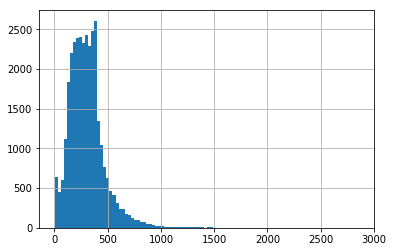

In [57]:
pd.Series(slidebase_enh.get_length_distribution()).hist(bins=100)

In [62]:
transcription_factors_bed.head()

1	10073	10329	ZBTB33	354
1	10149	10413	CEBPB	201
1	16110	16390	CTCF	227
1	29198	29688	TAF1	184
1	29275	29591	GABPA	198
1	89795	90051	USF1	185
1	91156	91580	CTCF	223
1	104859	105089	CTCF	106
1	138850	139274	CTCF	166
1	235541	235877	SP1	120


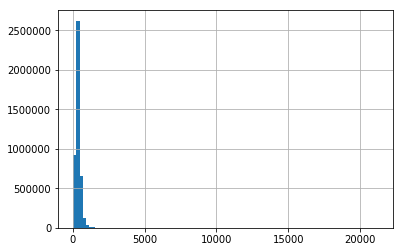

In [74]:
pd.Series(transcription_factors_bed.get_length_distribution()).hist(bins=100)

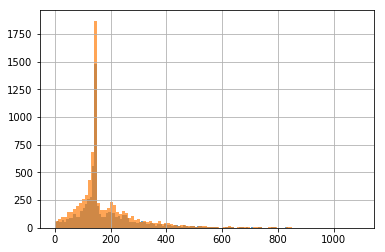

In [72]:
[pd.Series(x.get_length_distribution()).hist(bins=100, alpha=0.7) for x in div_trans_beds_filter_merged]

# Application to MS dataset
## Input

In [28]:
ms_meta = pd.read_csv('../../ms_enh/metadata/metadata.csv')

# Get Healthy bams
healthy_bams = ['../../ms_enh/results/snakemake/star/bams/' + x + '.bam' for x in 
                ms_meta.loc[ms_meta.Main.isin(['ia', 'Healthy_control'])].loc[:,'Petient ID']]

# Get ms bams
rrms_bams = ['../../ms_enh/results/snakemake/star/bams/' + x + '.bam' for x in 
               ms_meta.loc[ms_meta.Diagnose == 'RRMS'].loc[:,'Petient ID']]

In [29]:
rrms_bams

['../../ms_enh/results/snakemake/star/bams/Mono_85.bam',
 '../../ms_enh/results/snakemake/star/bams/Mono_125.bam',
 '../../ms_enh/results/snakemake/star/bams/Mono_129.bam',
 '../../ms_enh/results/snakemake/star/bams/Mono_136.bam',
 '../../ms_enh/results/snakemake/star/bams/Mono_138.bam']

## Detect divergent transcription in MS dataset

In [15]:
healthy_div_trans_beds = [get_divergent_transcription_beds(bam) for bam in healthy_bams]
healthy_div_trans_merged = [bed.merge(outfolder='../results/from_bam') for bed in healthy_div_trans_beds]

In [17]:
ms_div_trans_beds = [get_divergent_transcription_beds(bam) for bam in ms_bams]
ms_div_trans_merged = [bed.merge(outfolder='../results/from_bam') for bed in ms_div_trans_beds]

KeyboardInterrupt: 

## Select intervals overlapping with CAGE dataset divergent transcription events

In [16]:
div_trans_beds_merged_filter = [bed.intersect(cage_minus_bed, supp_args='-wa')\
                                .intersect(cage_plus_bed, supp_args='-wa')
                                for bed in div_trans_beds_merged]

NameError: name 'cage_minus_bed' is not defined